<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/Fetal%20ECG%20ICA%20detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Источник:

https://pmc.ncbi.nlm.nih.gov/articles/PMC5401132/pdf/JBPE-7-37.pdf

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
import time

# Load ECG data

https://physionet.org/content/aami-ec13/1.0.0/

In [ ]:
start = time.time(); noise_flag = False

# contains measurements with Fs = 720Hz and duration = 10 sec
Fs = 720 ; duration = 10 ; n_samples = int(duration*Fs)
t = [(1./Fs)*t for t in range(0,n_samples)]
t = np.asarray(t)
# We dont know the period of those signals
#s1 = (np.loadtxt('aami3a.txt'))[:,1]
s1 = (np.loadtxt('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/ecg-aami3a.txt'))[:,1]
s2 = (np.loadtxt('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/ecg-aami3b.txt'))[:,1]
s3 = (np.loadtxt('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/ecg-aami4a.txt'))[:,1]

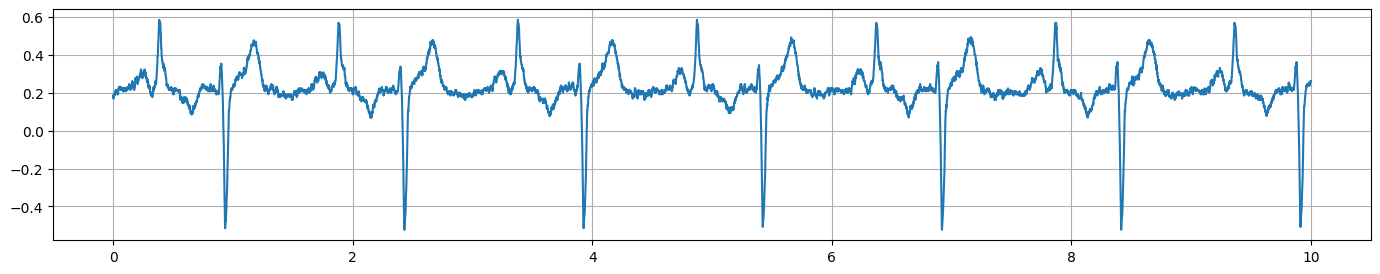

In [ ]:
plt.rcParams["figure.figsize"] = (17,3)
plt.plot(t,s1)
plt.grid()

In [ ]:
S = (np.c_[s1,s2,s3]).T
#del s1,s2,s3
mode = 'normal'
if mode == 'easy':
    B = np.array([(0.9,0.05,0.05),(0.05,0.9,0.05),(0.05,0.05,0.9)])
elif mode == 'normal':
    B = np.array([(0.6,0.3,0.1),(0.1,0.6,0.3),(0.3,0.1,0.6)])
elif mode == 'hard':
    B = np.random.randn(S.shape[0],S.shape[0])
else :
    raise ValueError("mode variable has undentified value")
X = np.dot(B,S)

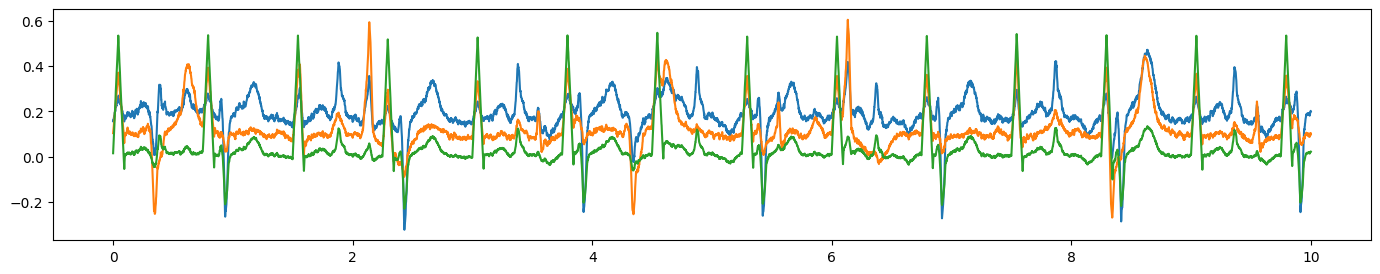

In [ ]:
plt.plot(t, X.T)

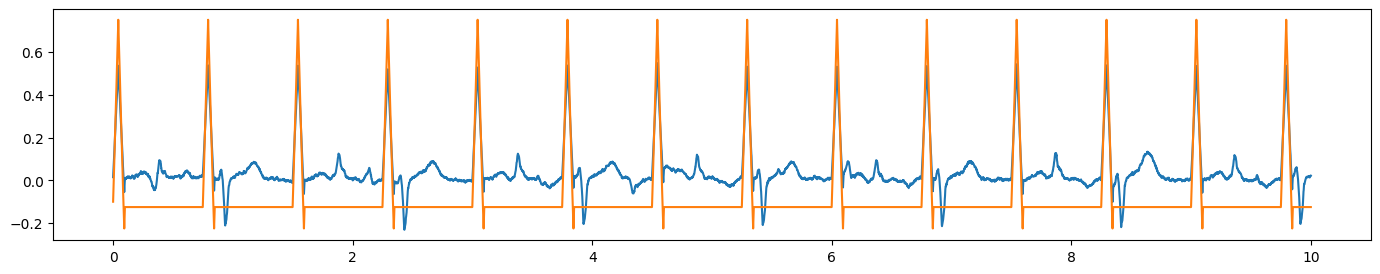

In [ ]:
plt.plot(t, X[2,:].T, t, S[2,:])

# ICA algorithm definition

In [ ]:
import numpy as np
from scipy import linalg as la

def mean_remove(X,rows,cols):
    '''
    PARAMETERS:
    X(array rows,cols):array that needs its mean value removed from all observations
    OUTPUTS:
    X_tilde (array rows,cols):array with zero mean
    '''
    p,n = rows,cols
    # We compute the mean value of the columns of X array and
    # reshape in a px1 array (p = number of different signals)
    mx = X.mean(axis=-1).reshape((p,1))
    # remove the mean matrix(px1) from the signals
    X_tilde = X - mx.dot(np.ones((1,n)))

    # Check if mean of X_tilde is close to zero
    mxt = X_tilde.mean(axis=-1).reshape((p,1))
    if np.all(np.abs(mxt) > 10**(-7)):
        raise ValueError("Mean remove has failed")

    return X_tilde

def pca_eig(X,comp):
    p,n = X.shape
    if(comp > min(X.shape)):
        print("Principal components must be less than signals")
        comp = min(X.shape)
    # Compute the covariance matrix of X
    Cx = np.cov(X)
    # e is the eigvector matrix where i-th column
    # responds to i-th eigvalue
    e,V = la.eig(Cx)
    # returns index sort in ascending order and reverse it
    eig_sort = np.argsort(e)[::-1]
    # re-arrange the vectors in the correct order
    e,V = e[eig_sort] , V[:,eig_sort]
    # keep the N first eigvalues and eigvectors as given by components
    e,V = e[:comp] , V[:,:comp]
    return e,V

def data_whitening(X,e,V):
    '''
    PARAMETERS:
    X(array p,n): array that will be whiten
    e(array p,1): eigvalues of X array that are sorted in descending order
    V(array p,p): matrix that consists the right eigvectors that corresponds
                  on each eigvalue
    OUTPOUTS:
    Z(array p,n): array that has whitened
    A(array p,p): whiten trasformation matrix

    NOTES:
    1) The white trasformation is reversible
    2) Must perform after PCA algorithm
    '''
    # Compute D^(-1/2) matrix (D= diag(d1,..,dp))
    D = np.diag(1./np.sqrt(e))
    A = (np.real(V@D)).T
    # A = D^(-1/2)*V.T
    #print((V@D).T - D@V.T)
    #A = np.real(D@V.T)
    Z = np.real(np.dot(A,X))
    return Z,A

In [ ]:
import numpy as np
from numpy import linalg as la

In [ ]:
import numpy as np
from numpy import linalg as la

def ica_def(X,comp,max_it,tol,g,gdot,w_init,alpha):
    '''
    PARAMETERS:
    X(array p,n): "white" array of signals that we need to estimate
    comp(int): independent components that we need to estimate
    max_it(int): maximum iterations of algorithm running
    tol(float): tolerance error that the algorithm converge
    g(function): contrast function that we define on fast_ica function
    gdot(function): contrast function that we define on fast_ica function
    w_init(array p,p): initial weights array
    alpha(float): parameter for g and gdot
    OUTPUTS:
    W(array p,p): estimated un-mixing matrix

    NOTES:
    We use deflational orthogonalization based on Gram-Schidt method
    for un-mixing matrix

    '''
    # prelocate un-mixing matrix
    W = np.zeros((comp,comp) , dtype = np.float64)
    p,n = X.shape
    # We choose comp indepented components to estimate
    for i in range(comp):
        # Choose an initial value and normalize it
        w = w_init[i,:].copy()
        w /= la.norm(w)

        iterations = 0 ; lim = 1.01
        # we set lim = 1.01 to be sure that the algorithm will run at least one time
        while( (iterations < max_it -1 ) and (lim > tol) ):
            # Calculate w*X product in order to calculate g(w*X) and g'(w*X)
            wtx = np.dot(w,X)[np.newaxis,:] # shape 1xn
            gwtx = g(wtx,alpha) # shape 1xn
            gdotwtx = gdot(wtx,alpha) # shape 1xn
            # the first term of w1 computes the mean value for all the rows of X*g(wX).T (vector)
            # and the second term computes the mean value of g'(w*X) matrix (number)
            w1 = (X@gwtx.T).mean(axis=1) - (np.mean(gdotwtx))*w # shape 1xp
            '''
            Gram - Schmidt method:
            After with estimate wp vectors , we do the one unit algorithm for wp+1
            and after every iteration step we substract from wp+1 the projections
            (wp+1*wj)wj j=1, ..,p of the previously estimated vectors
            and then we normalize the wp+1
            '''
            temp = np.zeros_like(w1)
            for j in range(i):
                wt = W[j,:].copy()
                # Calculate sum{(w1*w)w}
                temp+= (w1@wt)*wt
            w1-=temp
            # Normalization
            w1/=la.norm(w1)
            # the algorithm converge when the inner product of W(k+1)
            # and W(k) is close to 1. So we define lim as the absolute sum of the
            # inner product w1 and w and we subtract it from 1
            lim = np.abs(np.abs((w1*w).sum())-1)
            w = w1 ; iterations+=1
        W[i,:] = w
        '''
        The algorithm ends if one of below coditions is fullfilled
        i) The inner product of W(k+1) and W(K) is close to 1
        ii) If it surpasses the maximum number of iterations
        in the second , case the algorithm might not coverged
        '''
    return W

In [ ]:
def ica_sym(X,comp,max_it,tol,g,gdot,w_init,alpha):
    '''
    PARAMETERS:
    X(array p,n): "white" array of signals that we need to estimate
    comp(int): independent components that we need to estimate
    max_it(int): maximum iterations of algorithm running
    tol(float): tolerance error that the algorithm converge
    g(function): contrast function that we define on fast_ica function
    gdot(function): contrast function that we define on fast_ica function
    w_init(array p,p): initial weights array
    alpha(float): parameter for g and gdot
    OUTPUTS:
    W(array p,p): estimated un-mixing matrix

    NOTES:
    We use symmetrical orthogonalization for the whole un-mixing matrix
    '''
    # We choose the initial matrix and we normalize that
    W = w_init.copy()
    W /= np.sqrt(sum (sum(W**2)))
    # Orthogonalize through sqrt of W W.T  matrix
    # Compute eigvalues of W@W.T
    ew,Vw = la.eig(W@W.T)
    # Make the diagonal matrix with the eigvalues
    D_sqrt = np.diag(1./np.sqrt(ew))
    # Compute the square root of W W.T
    sqrt_WWT = (Vw @ D_sqrt)@Vw.T
    # W = sqrt(WW.T) * W
    W = sqrt_WWT@W

    # prellocate the correct un-mixing matrix
    W1 = np.zeros_like(W,dtype = float)

    iterations = 0 ; lim = 1.01
    # we set lim = 1.01 to be sure that the algorithm will run at least one time
    while((lim>tol) and (iterations < max_it -1)):
        for i in range(comp):
            w = W[i,:].copy()
            w = w/la.norm(w)
            # Calculate w*X product in order to calculate g(w*X) and g'(w*X)
            wtx = np.dot(w,X)[np.newaxis,:] #shape 1xn
            gdotwtx = gdot(wtx,alpha) #shape 1xn
            gwtx = g(wtx,alpha) #shape 1xn
            # the first term of w1 computes the mean value for all the rows of X*g(wX).T (vector)
            # and the second term computes the mean value of g'(w*X) matrix (number)
            w1 = np.mean(X.dot(gwtx.T),axis=1) - (np.mean(gdotwtx))*w #shape 1xp
            W1[i,:] = w1
        '''
        After we compute all wp vectors, we do the symmetric orthogonalization
        with the square root General Eigvalue Decompotion of WW.T matrix
        '''
        # Same procedure as the beginning
        ew1,Vw1 = la.eig(W1@W1.T)
        D1_sqrt = np.diag(1./np.sqrt(ew1))
        sqrt_W1W1T = (Vw1 @ D1_sqrt)@Vw1.T
        W1 = sqrt_W1W1T@W1
        # the algorithm converge when the inner product of W(k+1)
        # and W(k) is close to identity matrix. So we define lim as the maximum element
        # of W_new @ W_old.T - I_n
        lim = np.max(np.abs(np.diag(np.dot(W1,W.T))-np.identity(comp)))
        W = W1 ; iterations+=1
    return W


ICA assumes that the observed data 𝐱 are a linear combination of independent components: 𝐱=𝐀𝐬, where 𝐀 is usually called mixing matrix.

Covariance matrix of the data is then given by 𝐀𝐀⊤, because the covariance matrix of independent components 𝐬 is identity (indeed, independent components must have zero correlation between each other and are assumed to be scaled to have unit variance each). This means that if the data are pre-whitened, then 𝐀 must be an orthogonal matrix. This is often convenient.

In [ ]:
def fastica(X,n_comp=None,algorithm = 'deflation',whiten=True,fc = 'exp',alpha = 1.0,
            max_it = 10000,tol = 10**-6,w_init = None):
    '''
    PARAMETERS:
    X ( array p,n) : contains the observations measured on p variables
    OPTIONAL:
    n_comp (int) : number of components to extract
    algorithm(string 'symmetric' or 'deflational') : FastICA solving method
    whiten (bool) : do data whitening .If False , we assume that the data is already whiten
    fc ( string 'logcosh'/'exp'/'cube') : form of G function for comuting the negentropy
    alpha (float) : only use for fc = 'logcosh' . Default is 1.0
    max_it(int) : maximum iteration number
    tol(float) : tolerance which the um-mixing matrix is considered that has converged
    w_init ( array n_comp,n_comp) : initial values for un-mixing array

    OUTPOUTS:
    K(array n_comp,p): pre-whitening matrix
    W(array n_comp,n_comp): estimated un-mixing matrix
    S(array p,n): estimated source signal matrix

    '''
    if (alpha < 1.0) or (alpha > 2.0) :
        raise ValueError("alpha must be in [1,2]")

    if type(fc) is str:
        if fc == 'logcosh':
            def g(x,alpha):
                return np.tanh(x)
            def gdot(x,alpha):
                return alpha*(1 - (np.tanh(x))**2)
        elif fc == 'exp':
            def g(x,alpha):
                return x*np.exp(-0.5*(x**2))
            def gdot(x,alpha):
                return np.exp(-0.5*(x**2))*(1-x**2)
        elif fc == 'cube':
            def g(x,alpha):
                return x**3
            def gdot(x,alpha):
                return 3*x**2
        else:
            raise ValueError("Function does not included.")

    sensors,samples = X.shape

    if n_comp is None :
        n_comp = int(min(sensors,samples))
    elif (n_comp > min(sensors,samples)):
        n_comp = min(sensors,samples)
        print("Components to large.It was set",n_comp)

    if whiten :
        # Centering the columns / variables
        X = mean_remove(X,sensors,samples)
        # Do the PCA algorithm and then the data whitening
        eig,e = pca_eig(X,n_comp)
        Z,K = data_whitening(X,eig,e)
    else:
        Z = X.copy()
        #K = None
        K = np.identity(X.shape[0])

    if w_init is None:
        # Choose random initial values
        # ||w|| must be 1
        w_init = np.random.normal(size = (n_comp,n_comp))
    else:
        w_init = np.asarray(w_init)
        if w_init.shape != (n_comp,n_comp):
            raise ValueError("Wrong Shape. The correct dimensions are",(n_comp,n_comp))

    if algorithm == 'symmetric':
        W = ica_sym(Z,n_comp,max_it,tol,g,gdot,w_init,alpha)
    elif algorithm == 'deflation':
        W = ica_def(Z,n_comp,max_it,tol,g,gdot,w_init,alpha)
    else:
        raise ValueError("Wrong Argument")
    S_e = W@(K@X)
    return K,W,S_e,Z

# Use ICA algotithm for fetal ECG extraction

https://journal.r-project.org/archive/2018/RJ-2018-046/RJ-2018-046.pdf

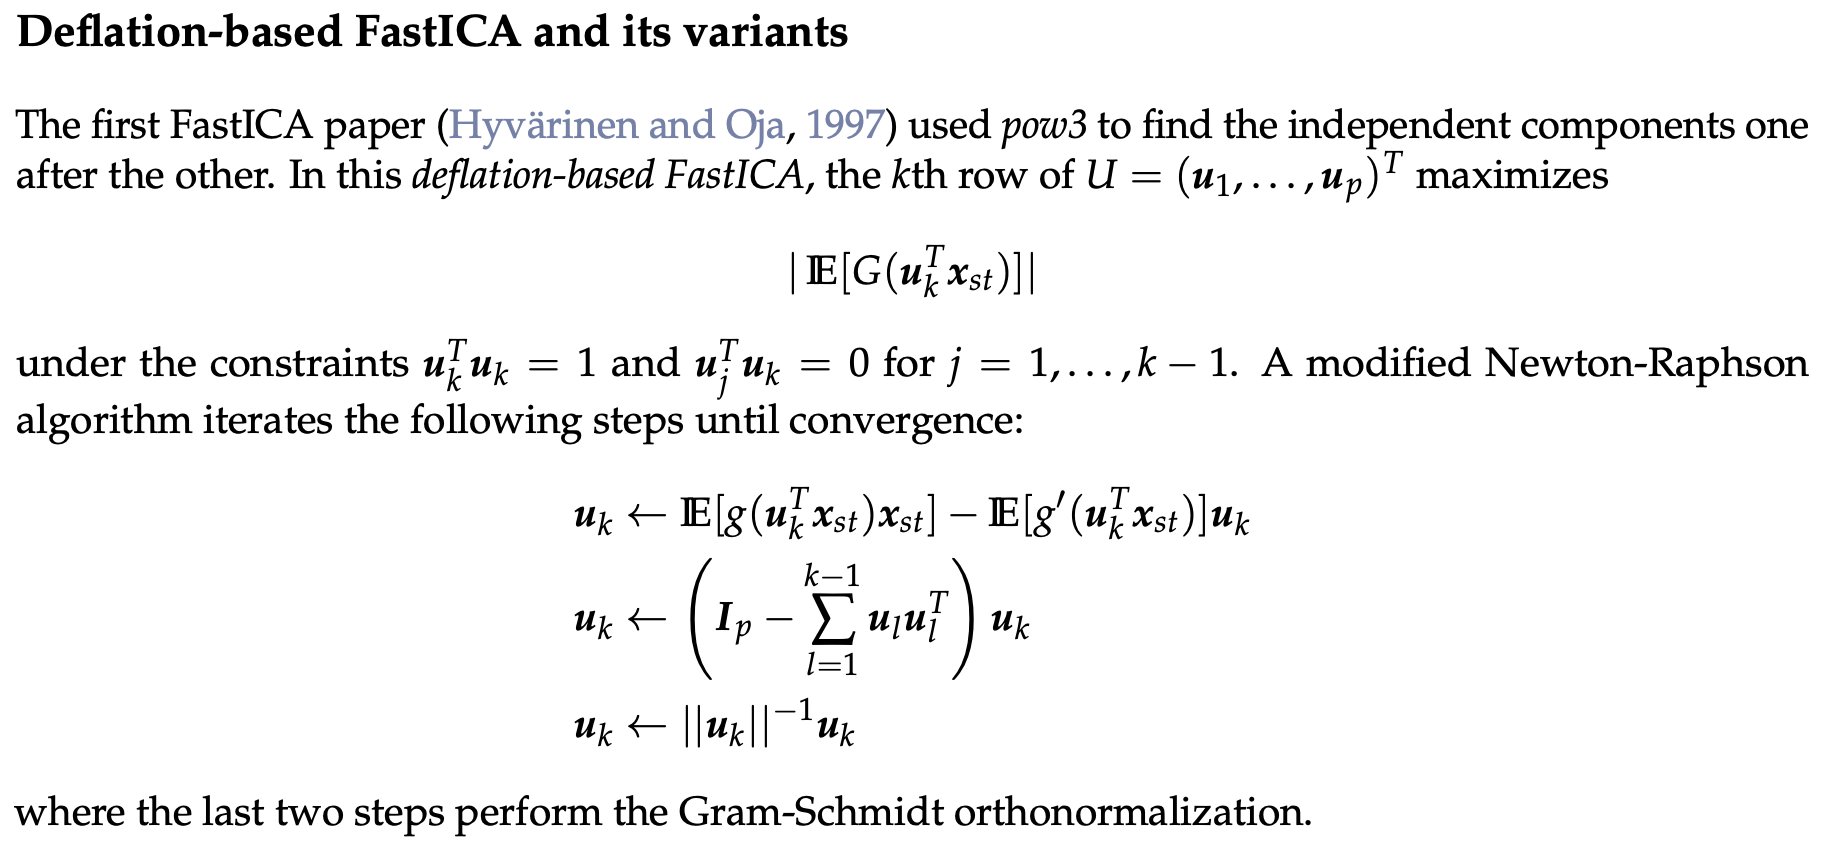

A. Hyvärinen and E. Oja. A fast fixed-point algorithm for independent component analyis. Neural Computation, 9:1483–1492, 1997. doi: 10.1162/neco.1997.9.7.1483. [p148, 149]

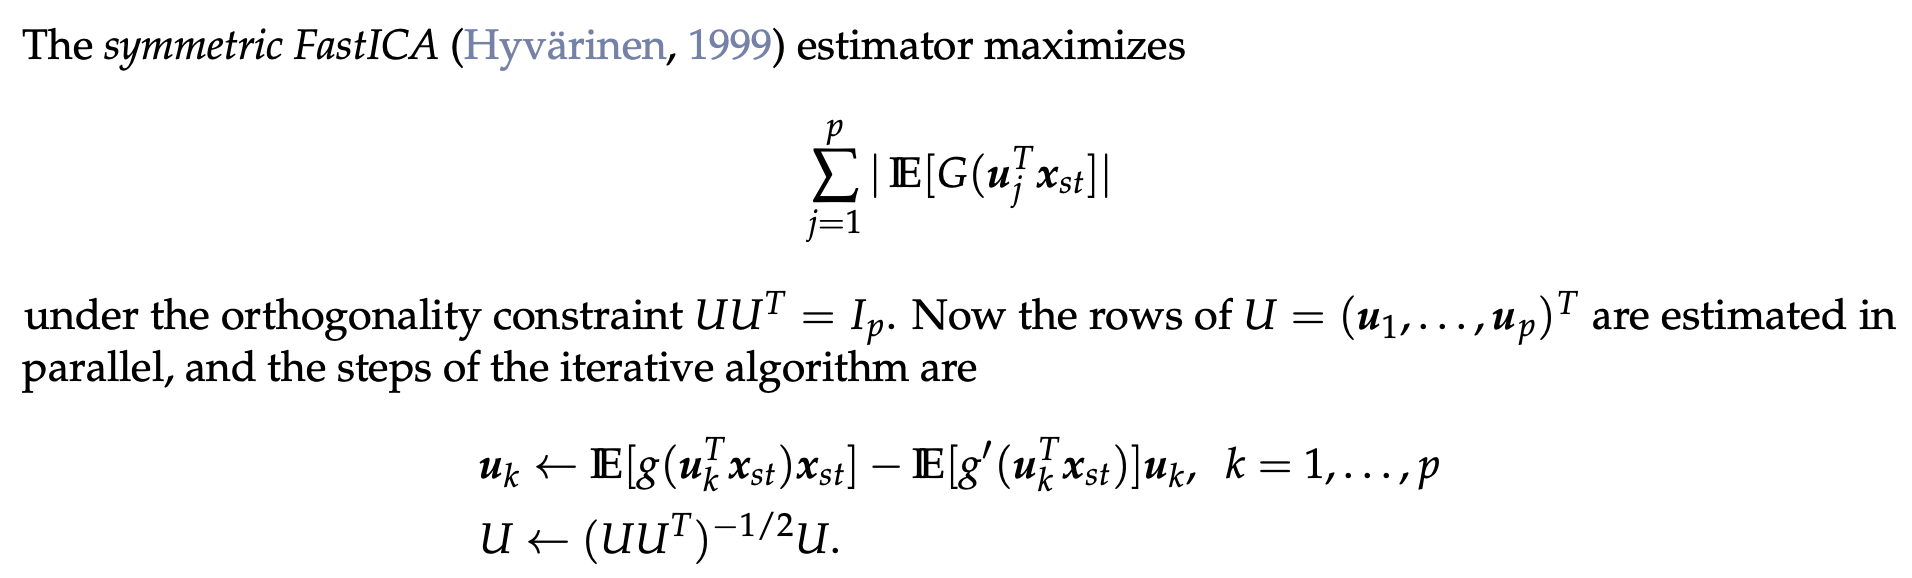

A. Hyvärinen. Fast and robust fixed-point algorithms for independent component analysis. IEEE Transactions on Neural Networks, 10:626–634, 1999. doi: 10.1109/72.761722. [p148, 149, 150]

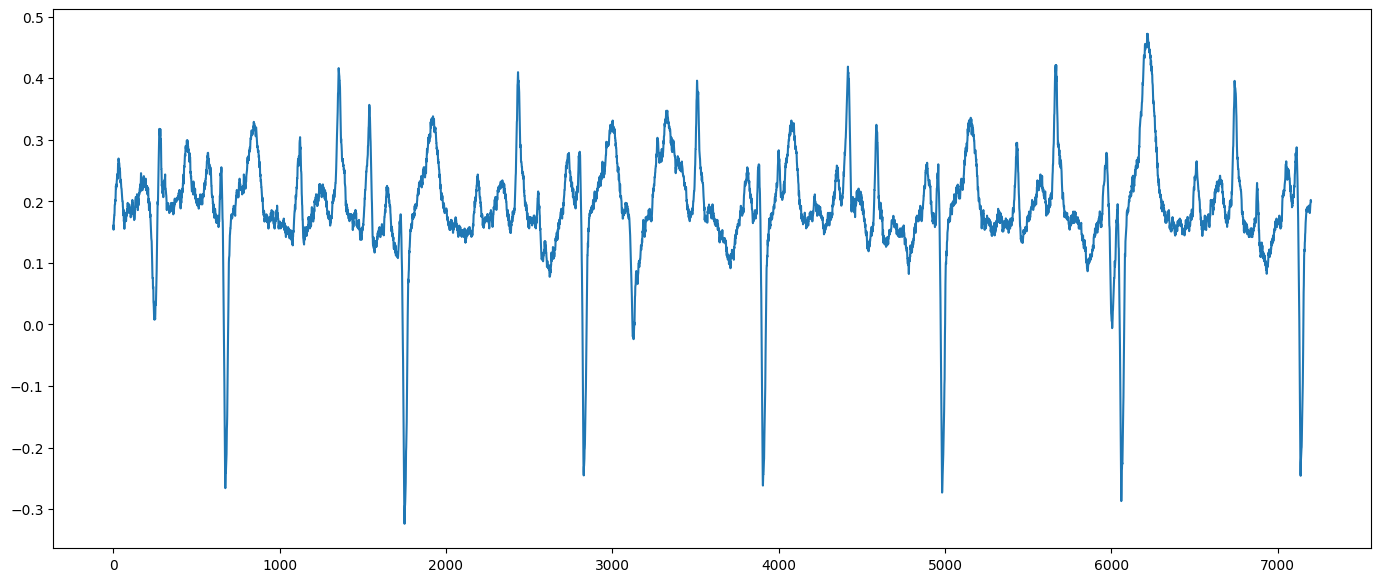

In [ ]:
plt.plot(X[0,:])

In [ ]:

ica_comp = min(S.shape)
# The lines of X present the signals and the columns present the
# observations of each signal at kTs time
init = np.random.normal(size = (ica_comp,ica_comp))
#algorithm = 'symmetric' , 'deflation'
#fc = cube / logcosh / exp


Kd,Wd,Yd,Zd = fastica(X,algorithm = 'deflation',whiten=False,fc = 'cube', w_init = init)
Ks,Ws,Ys,Zs = fastica(X,algorithm = 'symmetric',whiten=False,fc = 'cube',w_init = init)

print("Time Evaluated:",time.time()-start,"seconds")
#%%

Time Evaluated: 6583.884321928024 seconds


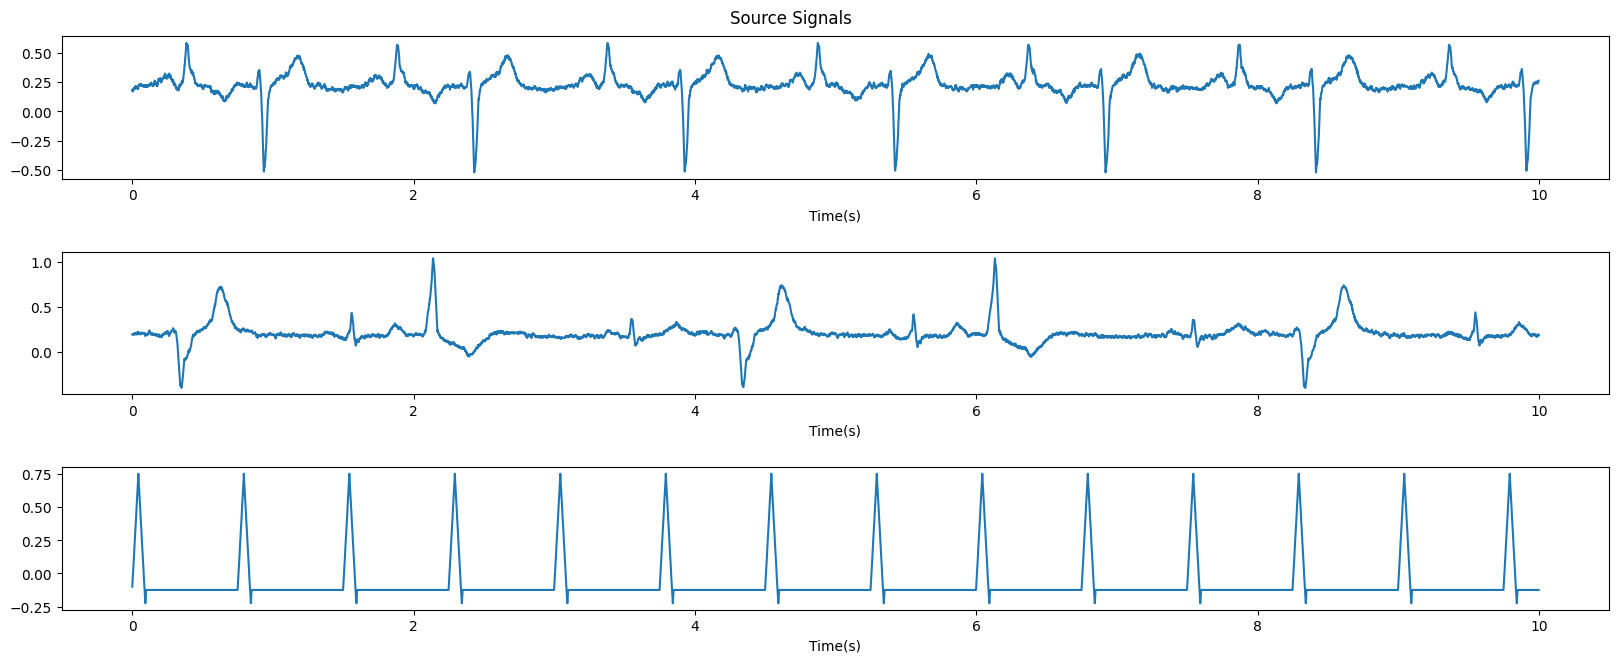

In [ ]:

top=0.941 ; bottom=0.122 ;left=0.071 ;right=0.981 ; hspace=0.512 ;wspace=0.15
fig = plt.figure()
fig.suptitle("Source Signals")
plt.subplot(311)
plt.plot(t,S[0,:])
plt.xlabel("Time(s)")
plt.subplots_adjust(top=0.941, bottom=0.122, left=0.071, right=0.981, hspace=0.512, wspace=0.15)
plt.subplot(312)
plt.plot(t,S[1,:])
plt.xlabel("Time(s)")
plt.subplots_adjust(top=0.941, bottom=0.122, left=0.071, right=0.981, hspace=0.512, wspace=0.15)
plt.subplot(313)
plt.plot(t,S[2,:])
plt.xlabel("Time(s)")
plt.subplots_adjust(top=0.941, bottom=0.122, left=0.071, right=0.981, hspace=0.512, wspace=0.15)
#plt.waitforbuttonpress() ; plt.close()

Text(0.5, 0, 'Time(s)')

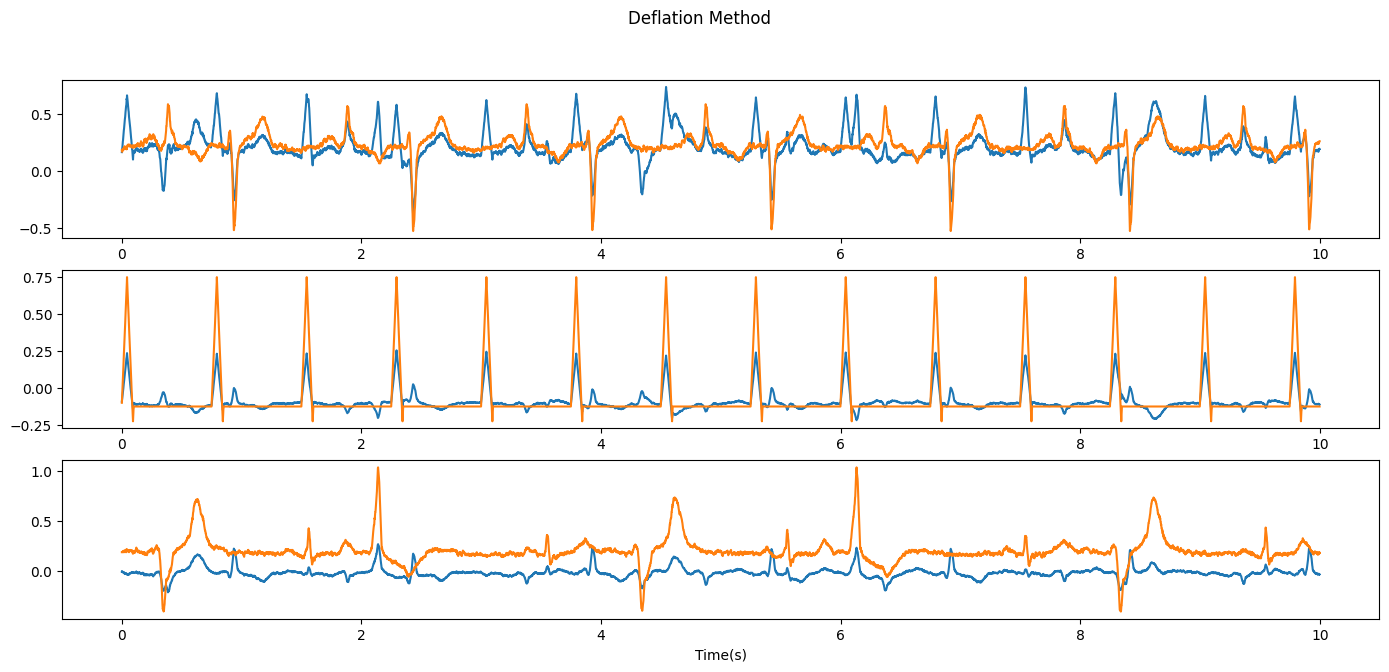

In [ ]:
plt.rcParams["figure.figsize"] = (17,7)
#%%
fig = plt.figure()
fig.suptitle("Deflation Method")
plt.subplot(311)
plt.plot(t,Yd[0,:], t, S[0,:])
plt.subplot(312)
plt.plot(t,Yd[1,:], t, S[2,:])
plt.subplot(313)
plt.plot(t,Yd[2,:], t, S[1,:])
plt.xlabel("Time(s)")


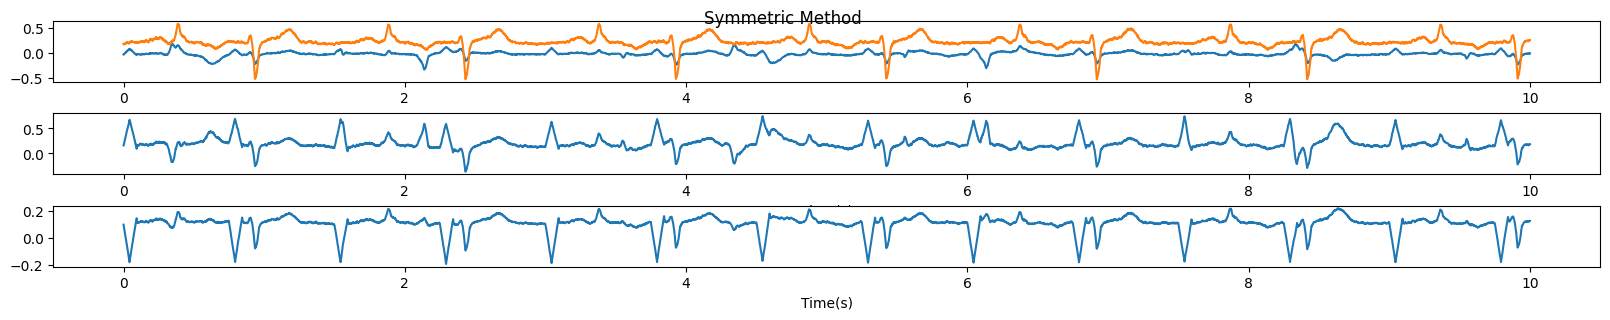

In [ ]:

#%%
fig = plt.figure()
fig.suptitle("Symmetric Method")
plt.subplot(311)
plt.plot(t,Ys[0,:], t, S[0,:])
plt.xlabel("Time(s)")
plt.subplots_adjust(top=0.941, bottom=0.122, left=0.071, right=0.981, hspace=0.512, wspace=0.15)
plt.subplot(312)
plt.plot(t,Ys[1,:])
plt.xlabel("Time(s)")
plt.subplots_adjust(top=0.941, bottom=0.122, left=0.071, right=0.981, hspace=0.512, wspace=0.15)
plt.subplot(313)
plt.plot(t,Ys[2,:])
plt.xlabel("Time(s)")
plt.subplots_adjust(top=0.941, bottom=0.122, left=0.071, right=0.981, hspace=0.512, wspace=0.15)


# Fast ICA from libraty

In [ ]:
transformer = FastICA(n_components=3,
        random_state=0,
        whiten='arbitrary-variance')
X_transformed = transformer.fit_transform(X.T)

S_ica = transformer.fit(X.T).transform(X.T)

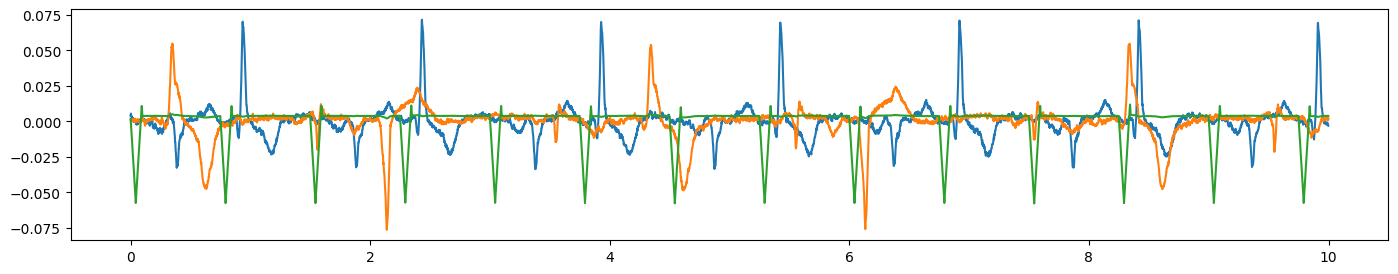

In [ ]:
plt.rcParams["figure.figsize"] = (17,3)

plt.plot(t,S_ica)